# Week 2: Predicting time series

Welcome! In the previous assignment you got some exposure to working with time series data, but you didn't use machine learning techniques for your forecasts. This week you will be using a deep neural network to create forecasts to see how this technique compares with the ones you already tried out. Once again all of the data is going to be generated.

Let's get started!

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Generating the data


The next cell includes a bunch of helper functions to generate and plot the time series:

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), 
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

You will be generating time series data that greatly resembles the one from last week but with some differences.

**Notice that this time all the generation is done within a function and global variables are saved within a dataclass. This is done to avoid using global scope as it was done in during the previous week.**

If you haven't used dataclasses before, they are just Python classes that provide a convenient syntax for storing data. You can read more about them in the [docs](https://docs.python.org/3/library/dataclasses.html). 

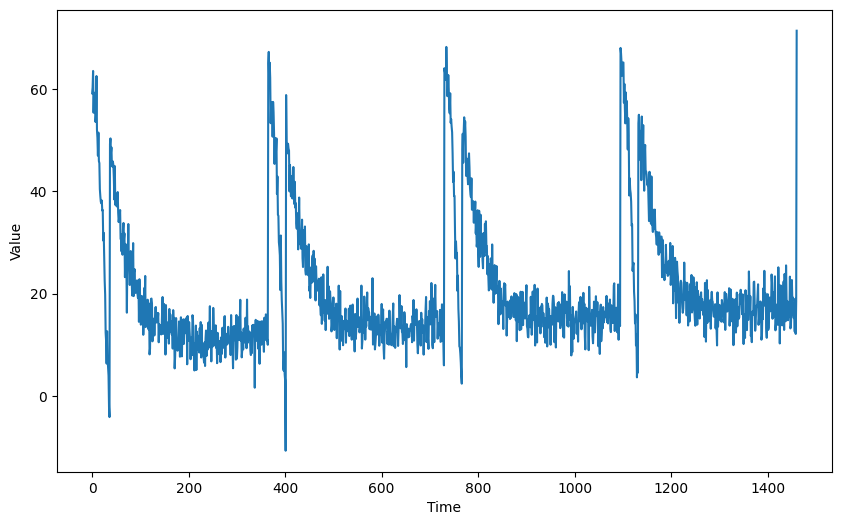

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Splitting the data

Since you already coded the `train_val_split` function during last week's assignment, this time it is provided for you:

In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

## Processing the data

As you saw on the lectures you can feed the data for training by creating a dataset with the appropiate processing steps such as `windowing`, `flattening`, `batching` and `shuffling`. To do so complete the `windowed_dataset` function below.

Notice that this function receives a `series`, `window_size`, `batch_size` and `shuffle_buffer` and the last three of these default to the "global" values defined earlier.

Be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) about `TF Datasets` if you need any help.

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    
    ### START CODE HERE
    
    # Create dataset from the series
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Slice the dataset into the appropriate windows
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    
    # Flatten the dataset
    dataset = dataset.flat_map(lambda x: x.batch(window_size+1))
    
    # Shuffle it
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Split it into the features and labels
    dataset = dataset.map(lambda x: (x[:-1], x[-1]))
    
    # Batch it
    dataset = dataset.batch(batch_size).prefetch(1)
    
    ### END CODE HERE
    
    return dataset

To test your function you will be using a `window_size` of 1 which means that you will use each value to predict the next one. This for 5 elements since a `batch_size` of 5 is used and no shuffle since `shuffle_buffer` is set to 1.

Given this, the batch of features should be identical to the first 5 elements of the `series_train` and the batch of labels should be equal to elements 2 through 6 of the `series_train`.

In [6]:
# Test your function with windows size of 1 and no shuffling
test_dataset = windowed_dataset(series_train, window_size=1, batch_size=5, shuffle_buffer=1)

# Get the first batch of the test dataset
batch_of_features, batch_of_labels = next((iter(test_dataset)))

print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
print(f"batch_of_features is equal to first five elements in the series: {np.allclose(batch_of_features.numpy().flatten(), series_train[:5])}\n")
print(f"batch_of_labels is equal to first five labels: {np.allclose(batch_of_labels.numpy(), series_train[1:6])}")

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

batch_of_features is equal to first five elements in the series: True

batch_of_labels is equal to first five labels: True


**Expected Output:**

```
batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

batch_of_features is equal to first five elements in the series: True

batch_of_labels is equal to first five labels: True
```

## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define you layer architecture.

Complete the `create_model` function below. Notice that this function receives the `window_size` since this will be an important parameter for the first layer of your network.

Hint:
- You will only need `Dense` layers.
- Do not include `Lambda` layers. These are not required and are incompatible with the `HDF5` format which will be used to save your model for grading.
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.

In [89]:
def create_model(window_size=G.WINDOW_SIZE):

    ### START CODE HERE

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)
    ]) 

    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.SGD(momentum=0.9, learning_rate=1e-6)
                  )
    
    ### END CODE HERE

    return model

In [90]:
# Apply the processing to the whole training series
dataset = windowed_dataset(series_train)

# Save an instance of the model
model = create_model()

# Train it
model.fit(dataset, epochs=100)

Epoch 1/100


/Users/geonheekim/Desktop/tensorflow/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 203.5479
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 120.8200
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 112.7177
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 86.9703
Epoch 5/100


2024-04-23 23:17:18.223781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-23 23:17:18.291115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:18.355829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:18.420972: W tensorflow/core/framework/local_rendezvous.cc:404] Local re

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 76.7785
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 68.1411
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 66.2113
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 75.3480
Epoch 9/100


2024-04-23 23:17:18.486113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:18.553558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:18.619273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:18.679153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 53.3667
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 49.2757
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 56.0054
Epoch 12/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 20.8541

2024-04-23 23:17:18.744539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:18.826470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:18.889272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 52.2595
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 45.3160
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 51.0802
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 35.9245
Epoch 16/100


2024-04-23 23:17:18.957040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:19.021509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:19.083743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:19.144860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 52.2500
Epoch 17/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 45.1372
Epoch 18/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 47.0057
Epoch 19/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 44.0017
Epoch 20/100


2024-04-23 23:17:19.210445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:19.272785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:19.342612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:19.404724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 55.3461
Epoch 21/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 41.7319
Epoch 22/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 50.3961
Epoch 23/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 35.0878
Epoch 24/100


2024-04-23 23:17:19.463620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:19.530330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:19.594612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:19.655177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 39.3647
Epoch 25/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 41.8053
Epoch 26/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 40.2853
Epoch 27/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 33.7754
Epoch 28/100


2024-04-23 23:17:19.723694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:19.788535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:19.850883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:19.910620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 39.4309
Epoch 29/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 35.7632
Epoch 30/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 40.1563
Epoch 31/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 29.4058

2024-04-23 23:17:19.973030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:20.038186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:20.101362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 39.1710
Epoch 32/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 31.3584
Epoch 33/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 30.7554
Epoch 34/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 21.5957

2024-04-23 23:17:20.175228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:20.249895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:20.323348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 36.3319
Epoch 35/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 34.9883
Epoch 36/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 35.0602
Epoch 37/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 48.2498

2024-04-23 23:17:20.386440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:20.451900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:20.517827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 44.6447
Epoch 38/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 32.4335
Epoch 39/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 37.3515
Epoch 40/100


2024-04-23 23:17:20.596322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:20.674214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:20.751940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 39.0204
Epoch 41/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 31.0844
Epoch 42/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 38.5803
Epoch 43/100


2024-04-23 23:17:20.830437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:20.908557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:20.997865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 40.6533
Epoch 44/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 33.4975
Epoch 45/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 34.4199
Epoch 46/100


2024-04-23 23:17:21.070723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:21.149988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:21.228128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 33.5276
Epoch 47/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 29.4159
Epoch 48/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 44.3248
Epoch 49/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 13.5206

2024-04-23 23:17:21.305122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:21.371338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:21.437298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 26.1537
Epoch 50/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 31.1656
Epoch 51/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 34.4979
Epoch 52/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 17.9785

2024-04-23 23:17:21.515069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:21.591978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:21.665854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 27.8606
Epoch 53/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 28.0679
Epoch 54/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 39.8121
Epoch 55/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 18.2369

2024-04-23 23:17:21.730386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:21.795174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:21.868684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 37.0210
Epoch 56/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 43.8128
Epoch 57/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 37.1868
Epoch 58/100


2024-04-23 23:17:21.939653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:22.015220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:22.090775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 40.1888
Epoch 59/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 37.8498
Epoch 60/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 34.4353
Epoch 61/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 82.9563

2024-04-23 23:17:22.164566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:22.229760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:22.306897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 40.9764
Epoch 62/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 37.8178
Epoch 63/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 31.8047
Epoch 64/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 5.7481

2024-04-23 23:17:22.382833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:22.455735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:22.522249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:22.584522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 35.3970
Epoch 65/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 29.9976
Epoch 66/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 32.8739
Epoch 67/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 32.9284
Epoch 68/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 29.0124
Epoch 69/100


2024-04-23 23:17:22.648423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:22.710772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:22.773110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:22.839768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 27.0967
Epoch 70/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 37.2071
Epoch 71/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 35.3891
Epoch 72/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 26.5455
Epoch 73/100


2024-04-23 23:17:22.901396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:22.965660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:23.033735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:23.098193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 44.6367
Epoch 74/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 32.6913
Epoch 75/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 32.4865
Epoch 76/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 16.9403

2024-04-23 23:17:23.166990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:23.236506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:23.305030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 34.9433
Epoch 77/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 33.2190
Epoch 78/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 24.7177
Epoch 79/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 12.0027

2024-04-23 23:17:23.372981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:23.447977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:23.523459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 32.0807
Epoch 80/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 44.2482
Epoch 81/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 28.4945
Epoch 82/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 32.7170
Epoch 83/100


2024-04-23 23:17:23.586368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:23.660386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:23.721352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:23.780506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 31.0912
Epoch 84/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 28.8834
Epoch 85/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 36.0275
Epoch 86/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 20.7870

2024-04-23 23:17:23.854131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:23.933705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:24.007952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 30.8226
Epoch 87/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 31.1004
Epoch 88/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 34.5952
Epoch 89/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 39.6474
Epoch 90/100


2024-04-23 23:17:24.071923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:24.133765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:24.202824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:24.268166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 40.7044
Epoch 91/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 27.3239
Epoch 92/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 40.0811
Epoch 93/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 13.3243

2024-04-23 23:17:24.335998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:24.409174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:24.485601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 31.3845
Epoch 94/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 36.6384
Epoch 95/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 45.0305
Epoch 96/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 86.8703

2024-04-23 23:17:24.550766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:24.618201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:24.692482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 31.7793
Epoch 97/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 25.8489
Epoch 98/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 24.2885
Epoch 99/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 26.3420
Epoch 100/100


2024-04-23 23:17:24.754330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:24.817106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:24.878794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:17:24.944335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 27.1284


2024-04-23 23:17:25.006125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in the previous assignment:

In [91]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast. 

For this, run the cell below which uses the `generate_forecast` function to compute the forecast. This function generates the next value given a set of the previous `window_size` points for every point in the validation set.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

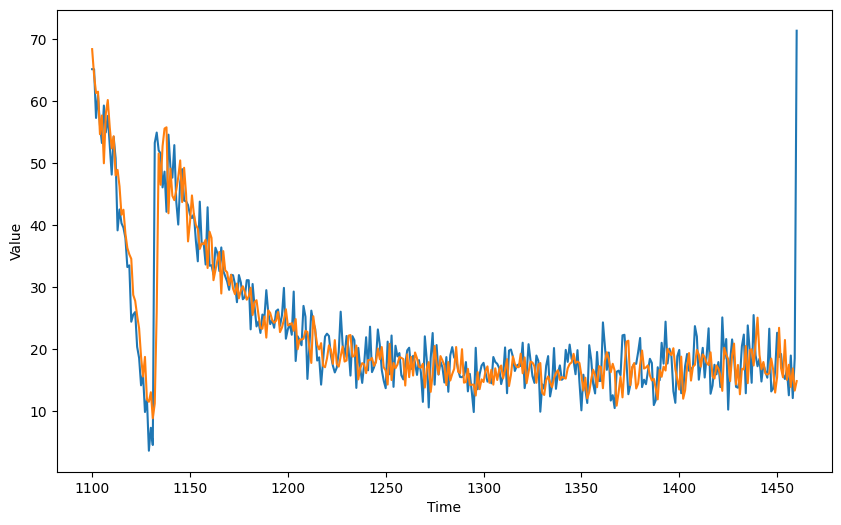

In [92]:
def generate_forecast(series=G.SERIES, split_time=G.SPLIT_TIME, window_size=G.WINDOW_SIZE):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results


# Save the forecast
dnn_forecast = generate_forecast()

# Plot it
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, dnn_forecast)

**Expected Output:**

A series similar to this one:

<div>
<img src="images/forecast.png" width="500"/>
</div>

In [93]:
mse, mae = compute_metrics(series_valid, dnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 33.12, mae: 3.58 for forecast


**To pass this assignment your forecast should achieve an MSE of 30 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save your model in a HDF5 file file which will be used for grading and after doing so, submit your assigment for grading.


- Make sure you didn't use `Lambda` layers in your model since these are incompatible with the `HDF5` format which will be used to save your model for grading.


- This environment includes a dummy `my_model.h5` file which is just a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**

In [94]:
# Save your model in HDF5 format
model.save('my_model.h5')

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series while also learning how to leverage Tensorflow's Dataset class to process time series data!

**Keep it up!**